In [84]:
import numpy as np
import matplotlib.pyplot as plt

def initialize_lattice(size):
    # Create a 2D array 'lattice' of dimensions size x size, initialized to 0
    lattice = np.zeros((size, size), dtype=int)
    return lattice

def compute_neighbor_indices(size):
    # Create an empty dictionary to store neighbor indices
    neighbor_indices = {}
    
    # Loop over each cell in the lattice
    for x in range(size):
        for y in range(size):
            # Calculate the neighbors with periodic boundary conditions
            neighbors = [
                ((x - 1) % size, y),   # Left neighbor
                ((x + 1) % size, y),   # Right neighbor
                (x, (y - 1) % size),   # Top neighbor
                (x, (y + 1) % size)    # Bottom neighbor
            ]
            # Store neighbors for each position in the dictionary
            neighbor_indices[(x, y)] = neighbors
            
    return neighbor_indices

def calculate_interaction_energy(lattice, site, particle, neighbor_indices, epsilon_AA, epsilon_BB, epsilon_AB):
    # Extract the coordinates of the site
    x, y = site
    # Initialize interaction energy
    interaction_energy = 0

    # Iterate over each neighbor of the site
    for neighbor in neighbor_indices[(x, y)]:
        neighbor_particle = lattice[neighbor]
        
        # If there's a particle at the neighboring site
        if neighbor_particle != 0:
            if particle == 1:  # Particle A
                if neighbor_particle == 1:
                    interaction_energy += epsilon_AA
                else:  # Neighbor is Particle B
                    interaction_energy += epsilon_AB
            else:  # Particle B
                if neighbor_particle == 2:
                    interaction_energy += epsilon_BB
                else:  # Neighbor is Particle A
                    interaction_energy += epsilon_AB
                    
    return interaction_energy

import numpy as np

def attempt_move(lattice, N_A, N_B, N_empty, neighbor_indices, params):
    # Extract lattice size and parameters
    size = lattice.shape[0]
    N_sites = size * size
    beta = 1 / params['T']
    epsilon_A = params['epsilon_A']
    epsilon_B = params['epsilon_B']
    epsilon_AA = params['epsilon_AA']
    epsilon_BB = params['epsilon_BB']
    epsilon_AB = params['epsilon_AB']
    mu_A = params['mu_A']
    mu_B = params['mu_B']

    # Decide whether to add or remove a particle
    if np.random.rand() < 0.5:  # Attempt to add a particle
        if N_empty == 0:
            return N_A, N_B, N_empty  # No empty sites available

        # Select a random empty site
        empty_sites = np.argwhere(lattice == 0)
        site = tuple(empty_sites[np.random.randint(len(empty_sites))])

        # Decide which particle to add
        if np.random.rand() < 0.5:
            particle = 1  # Particle A
            mu = mu_A
            epsilon = epsilon_A
            N_s = N_A
        else:
            particle = 2  # Particle B
            mu = mu_B
            epsilon = epsilon_B
            N_s = N_B

        # Calculate the change in energy
        delta_E = epsilon + calculate_interaction_energy(lattice, site, particle, neighbor_indices, epsilon_AA, epsilon_BB, epsilon_AB)
        acc_prob = min(1, (N_empty / (N_s + 1)) * np.exp(-beta * (delta_E - mu)))

        # Attempt the move based on acceptance probability
        if np.random.rand() < acc_prob:
            lattice[site] = particle
            if particle == 1:
                N_A += 1
            else:
                N_B += 1
            N_empty -= 1

    else:  # Attempt to remove a particle
        if N_sites - N_empty == 0:
            return N_A, N_B, N_empty  # No particles to remove

        # Select a random occupied site
        occupied_sites = np.argwhere(lattice != 0)
        site = tuple(occupied_sites[np.random.randint(len(occupied_sites))])
        particle = lattice[site]

        # Set parameters based on particle type
        if particle == 1:
            mu = mu_A
            epsilon = epsilon_A
            N_s = N_A
        else:
            mu = mu_B
            epsilon = epsilon_B
            N_s = N_B

        # Calculate the change in energy
        delta_E = -epsilon - calculate_interaction_energy(lattice, site, particle, neighbor_indices, epsilon_AA, epsilon_BB, epsilon_AB)
        acc_prob = min(1, (N_s / (N_empty + 1)) * np.exp(-beta * (delta_E + mu)))

        # Attempt the move based on acceptance probability
        if np.random.rand() < acc_prob:
            lattice[site] = 0  # Remove particle
            if particle == 1:
                N_A -= 1
            else:
                N_B -= 1
            N_empty += 1

    return N_A, N_B, N_empty

import numpy as np

def run_simulation(size, n_steps, params):
    # Initialize lattice and neighbor indices
    lattice = initialize_lattice(size)
    neighbor_indices = compute_neighbor_indices(size)
    N_sites = size * size

    # Initialize particle counts and empty site count
    N_A = 0
    N_B = 0
    N_empty = N_sites

    # Arrays to store coverage over time
    coverage_A = np.zeros(n_steps)
    coverage_B = np.zeros(n_steps)

    # Run the simulation for the specified number of steps
    for step in range(n_steps):
        # Attempt a move and update counts
        N_A, N_B, N_empty = attempt_move(lattice, N_A, N_B, N_empty, neighbor_indices, params)
        
        # Calculate coverage and store it
        coverage_A[step] = N_A / N_sites
        coverage_B[step] = N_B / N_sites

    return lattice, coverage_A, coverage_B



def plot_lattice(lattice, ax, title):
    size = lattice.shape[0]
    
    # Loop through the lattice to plot particles
    for x in range(size):
        for y in range(size):
            if lattice[x, y] == 1:
                # Plot a red circle for Particle A
                ax.plot(x + 0.5, y + 0.5, 'o', color='red', markersize=6)
            elif lattice[x, y] == 2:
                # Plot a blue circle for Particle B
                ax.plot(x + 0.5, y + 0.5, 'o', color='blue', markersize=6)
    
    # Set axis limits and labels
    ax.set_xlim(0, size)
    ax.set_ylim(0, size)
    ax.set_xticks(np.arange(0, size + 1, 1))
    ax.set_yticks(np.arange(0, size + 1, 1))
    ax.set_xticklabels([])  # Hide x-axis labels
    ax.set_yticklabels([])  # Hide y-axis labels
    
    # Set the grid to show the major ticks for clearer grid lines
    ax.grid(which='major', linestyle='-', color='black', linewidth=0.5)
    
    # Set the title of the plot
    ax.set_title(title)

     # Calculate the coverage ratio (H/N)
    total_H = np.sum(lattice == 1)  # Assuming 1 represents H in the lattice
    total_N = np.sum(lattice == 2)  # Assuming 2 represents N in the lattice
    fraction = total_H/total_N

    ratio_text = f'{total_H}/{total_N}, {fraction}'
    ax.text(0.5, -0.2, f'H/N = {ratio_text}', color='black', fontsize=10,
            ha='center', va='center', transform=ax.transAxes)


    return ax




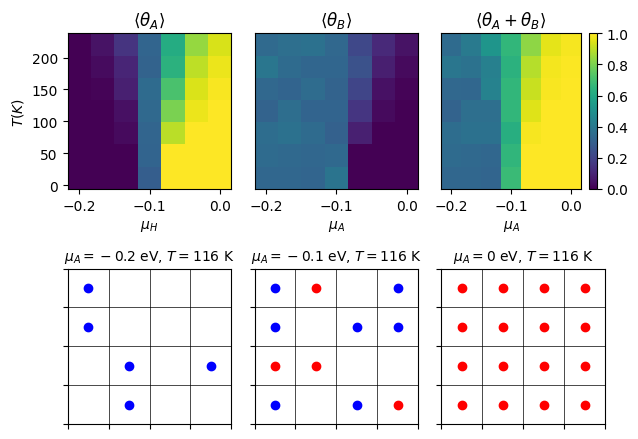

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


# Parameters
size = 4
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7)
Ts = np.linspace(0.001, 0.019, 7)
params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1,
            'epsilon_B': -0.1,
            'epsilon_AA': 0,
            'epsilon_BB': 0,
            'epsilon_AB': 0,
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k)
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_A = np.zeros((len(mus_A), len(Ts)))
mean_coverage_B = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_A, coverage_B = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_A[i // len(Ts), i % len(Ts)] = np.mean(coverage_A[-1000:])
    mean_coverage_B[i // len(Ts), i % len(Ts)] = np.mean(coverage_B[-1000:])

# Plot the T-mu_A phase diagram
fig, axs = plt.subplot_mosaic([[0, 1, 2], [3, 4, 5]], figsize=(6.5, 4.5))
#fig, axs = plt.subplots(2, 3, figsize=(6.5, 4.5))

Ts/=(8.617*10**-5) #Convert to Kelvin

# Mean coverage of H
axs[0].pcolormesh(mus_A, Ts, mean_coverage_A.T, cmap='viridis', vmin=0, vmax=1)
axs[0].set_title(r'$\langle \theta_A \rangle$')
axs[0].set_xlabel(r'$\mu_H$')
axs[0].set_ylabel(r'$T(K)$')

# Mean coverage of N
axs[1].pcolormesh(mus_A, Ts, mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[1].set_title(r'$\langle \theta_B \rangle$')
axs[1].set_xlabel(r'$\mu_A$')
axs[1].set_yticks([])

# Mean total coverage
cax = axs[2].pcolormesh(mus_A, Ts, mean_coverage_A.T + mean_coverage_B.T, cmap='viridis', vmin=0, vmax=1)
axs[2].set_title(r'$\langle \theta_A + \theta_B \rangle$')
axs[2].set_xlabel(r'$\mu_A$')
axs[2].set_yticks([])
fig.colorbar(cax, ax=axs[2], location='right', fraction=0.1)

# Plot the final lattice configuration

fontisize=10
# mu_A = -0.2 eV and T = 0.01 / k
axs[3] = plot_lattice(final_lattice[0, 3], axs[3], r'$\mu_A = -0.2$ eV, $T = 116$ K')
axs[3].set_title(r'$\mu_A = -0.2$ eV, $T = 116$ K', fontsize=fontisize)

# mu_A = -0.1 eV and T = 0.01 / k
axs[4] = plot_lattice(final_lattice[3, 3], axs[4], r'$\mu_A = -0.1$ eV, $T = 116$ K')
axs[4].set_title(r'$\mu_A = -0.1$ eV, $T = 116$ K', fontsize=fontisize)

# mu_A = 0 eV and T = 0.01 / k
axs[5] = plot_lattice(final_lattice[6, 3], axs[5], r'$\mu_A = 0$ eV, $T = 116$ K')
axs[5].set_title(r'$\mu_A = 0$ eV, $T = 116$ K', fontsize=fontisize)

plt.tight_layout()
plt.show()



In [81]:
#Ideal mixture of Nitrogen and Hydrogen

import numpy as np
import matplotlib.pyplot as plt

#A=Hydrogen->Varying value, limiting reagent
#B=Nitrogen->Constant value, excess 

# Parameters
size = 4
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7)
Ts = np.linspace(0.001, 0.065, 21)

params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1,
            'epsilon_B': -0.1,
            'epsilon_AA': 0,
            'epsilon_BB': 0,
            'epsilon_AB': 0,
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k))
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_H = np.zeros((len(mus_A), len(Ts)))
mean_coverage_N = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_H, coverage_N = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_H[i // len(Ts), i % len(Ts)] = np.mean(coverage_H[-1000:])
    mean_coverage_N[i // len(Ts), i % len(Ts)] = np.mean(coverage_N[-1000:])

print(mus_A)
Ts=Ts/(8.617*10**-5) #Convert to Kelvin
print(Ts)




[-0.2        -0.16666667 -0.13333333 -0.1        -0.06666667 -0.03333333
  0.        ]
[ 11.60496693  48.74086109  85.87675525 123.01264941 160.14854358
 197.28443774 234.4203319  271.55622606 308.69212023 345.82801439
 382.96390855 420.09980272 457.23569688 494.37159104 531.5074852
 568.64337937 605.77927353 642.91516769 680.05106185 717.18695602
 754.32285018]


In [82]:
#Figure out which paramaters are best
def find_optimal_conditions(mus_A, Ts, final_lattice):
    optimal_conditions = []
    
    for i, mu_A in enumerate(mus_A):
        for j, T in enumerate(Ts):
            # Calculate the total counts of H and N in the lattice
            lattice = final_lattice[i, j]
            total_H = np.sum(lattice == 1)  # Assuming 1 represents H in the lattice
            total_N = np.sum(lattice == 2)  # Assuming 2 represents N in the lattice
            
            # Avoid division by zero if there are no N atoms
            if total_N > 0:
                ratio_decimal = total_H / total_N
                # Check if the ratio is within the desired range (2 <= H:N <= 4)
                if 2 <= ratio_decimal <= 4:
                    ratio_fraction = f'{total_H}/{total_N}'
                    optimal_conditions.append({
                        'mu_H': mu_A,
                        'T': T,
                        'ratio_fraction': ratio_fraction,
                        'ratio_decimal': ratio_decimal
                    })
    
    # Print the results
    print("Optimal Conditions (H:N ratio between 2 and 4):")
    for condition in optimal_conditions:
        print(f"mu_H = {condition['mu_H']}, T = {condition['T']} K, H:N = {condition['ratio_fraction']} ({condition['ratio_decimal']:.2f})")
        
# Call the function with the parameters and final lattice configurations
find_optimal_conditions(mus_A, Ts, final_lattice)


Optimal Conditions (H:N ratio between 2 and 4):
mu_H = -0.1, T = 48.7408610885459 K, H:N = 6/2 (3.00)
mu_H = -0.1, T = 271.55622606475566 K, H:N = 6/3 (2.00)
mu_H = -0.06666666666666668, T = 160.14854357665078 K, H:N = 10/3 (3.33)
mu_H = -0.06666666666666668, T = 271.55622606475566 K, H:N = 10/4 (2.50)
mu_H = -0.06666666666666668, T = 494.37159104096554 K, H:N = 6/3 (2.00)
mu_H = -0.06666666666666668, T = 754.3228501798769 K, H:N = 9/3 (3.00)
mu_H = -0.033333333333333354, T = 271.55622606475566 K, H:N = 10/5 (2.00)
mu_H = -0.033333333333333354, T = 345.828014390159 K, H:N = 9/3 (3.00)
mu_H = -0.033333333333333354, T = 382.9639085528606 K, H:N = 11/4 (2.75)
mu_H = -0.033333333333333354, T = 420.09980271556225 K, H:N = 10/3 (3.33)
mu_H = -0.033333333333333354, T = 568.6433793663688 K, H:N = 10/3 (3.33)
mu_H = -0.033333333333333354, T = 754.3228501798769 K, H:N = 8/4 (2.00)
mu_H = 0.0, T = 420.09980271556225 K, H:N = 11/3 (3.67)
mu_H = 0.0, T = 494.37159104096554 K, H:N = 11/4 (2.75)
mu_H

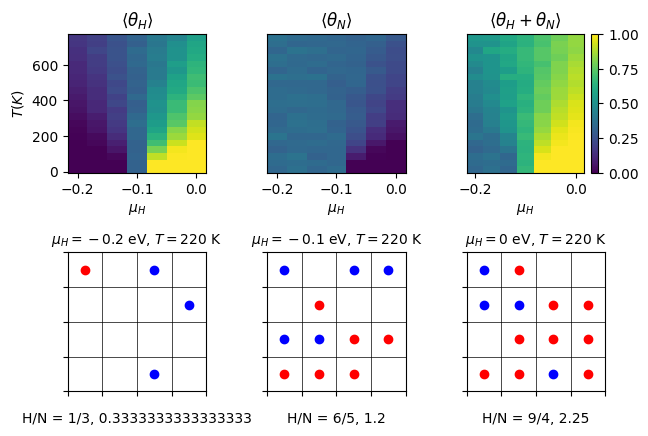

In [86]:


# Plot the final lattice configuration
# Plot the T-mu_A phase diagram
fig, axs = plt.subplot_mosaic([[0, 1, 2], [3, 4, 5]], figsize=(6.5, 4.5))
#fig, axs = plt.subplots(2, 3, figsize=(6.5, 4.5))


# Mean coverage of H
axs[0].pcolormesh(mus_A, Ts, mean_coverage_H.T, cmap='viridis', vmin=0, vmax=1)
axs[0].set_title(r'$\langle \theta_H \rangle$')
axs[0].set_xlabel(r'$\mu_H$')
axs[0].set_ylabel(r'$T(K)$')

# Mean coverage of N
axs[1].pcolormesh(mus_A, Ts, mean_coverage_N.T, cmap='viridis', vmin=0, vmax=1)
axs[1].set_title(r'$\langle \theta_N \rangle$')
axs[1].set_xlabel(r'$\mu_H$')
axs[1].set_yticks([])

# Mean total coverage
cax = axs[2].pcolormesh(mus_A, Ts, mean_coverage_H.T + mean_coverage_N.T, cmap='viridis', vmin=0, vmax=1)
axs[2].set_title(r'$\langle \theta_H + \theta_N \rangle$')
axs[2].set_xlabel(r'$\mu_H$')
axs[2].set_yticks([])
fig.colorbar(cax, ax=axs[2], location='right', fraction=0.1)

fontisize=10
# mu_A = -0.2 eV and T = 0.01 / k
axs[3] = plot_lattice(final_lattice[0, 19], axs[3], r'$\mu_H = -0.2$ eV, $T = 220$ K')
axs[3].set_title(r'$\mu_H = -0.2$ eV, $T = 220$ K', fontsize=fontisize)

# mu_A = -0.1 eV and T = 0.01 / k
axs[4] = plot_lattice(final_lattice[3, 19], axs[4], r'$\mu_H = -0.1$ eV, $T = 220$ K')
axs[4].set_title(r'$\mu_H = -0.1$ eV, $T = 220$ K', fontsize=fontisize)

# mu_A = 0 eV and T = 0.01 / k
axs[5] = plot_lattice(final_lattice[6, 19], axs[5], r'$\mu_H = 0$ eV, $T = 220$ K')
axs[5].set_title(r'$\mu_H = 0$ eV, $T = 220$ K', fontsize=fontisize)

plt.tight_layout()
plt.show()


In [36]:
#Repulsive Interaction

import numpy as np
import matplotlib.pyplot as plt

#A=Hydrogen->Varying value, limiting reagent
#B=Nitrogen->Constant value, excess 

# Parameters
size = 4
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7)
Ts = np.linspace(0.001, 0.019, 7)

params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1,
            'epsilon_B': -0.1,
            'epsilon_AA': 0.05,
            'epsilon_BB': 0.05,
            'epsilon_AB': 0.05,
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k))
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_H = np.zeros((len(mus_A), len(Ts)))
mean_coverage_N = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_H, coverage_N = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_H[i // len(Ts), i % len(Ts)] = np.mean(coverage_H[-1000:])
    mean_coverage_N[i // len(Ts), i % len(Ts)] = np.mean(coverage_N[-1000:])

Ts=Ts/(8.617*10**-5) #Convert to Kelvin




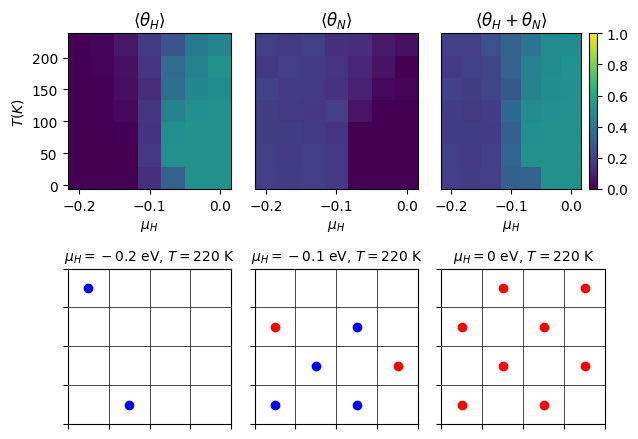

In [37]:
#REPULSION PLOTS


# Plot the final lattice configuration
# Plot the T-mu_A phase diagram
fig, axs = plt.subplot_mosaic([[0, 1, 2], [3, 4, 5]], figsize=(6.5, 4.5))
#fig, axs = plt.subplots(2, 3, figsize=(6.5, 4.5))


# Mean coverage of H
axs[0].pcolormesh(mus_A, Ts, mean_coverage_H.T, cmap='viridis', vmin=0, vmax=1)
axs[0].set_title(r'$\langle \theta_H \rangle$')
axs[0].set_xlabel(r'$\mu_H$')
axs[0].set_ylabel(r'$T(K)$')

# Mean coverage of N
axs[1].pcolormesh(mus_A, Ts, mean_coverage_N.T, cmap='viridis', vmin=0, vmax=1)
axs[1].set_title(r'$\langle \theta_N \rangle$')
axs[1].set_xlabel(r'$\mu_H$')
axs[1].set_yticks([])

# Mean total coverage
cax = axs[2].pcolormesh(mus_A, Ts, mean_coverage_H.T + mean_coverage_N.T, cmap='viridis', vmin=0, vmax=1)
axs[2].set_title(r'$\langle \theta_H + \theta_N \rangle$')
axs[2].set_xlabel(r'$\mu_H$')
axs[2].set_yticks([])
fig.colorbar(cax, ax=axs[2], location='right', fraction=0.1)

fontisize=10
# mu_A = -0.2 eV and T = 0.01 / k
axs[3] = plot_lattice(final_lattice[0, 6], axs[3], r'$\mu_H = -0.2$ eV, $T = 220$ K')
axs[3].set_title(r'$\mu_H = -0.2$ eV, $T = 220$ K', fontsize=fontisize)

# mu_A = -0.1 eV and T = 0.01 / k
axs[4] = plot_lattice(final_lattice[3, 6], axs[4], r'$\mu_H = -0.1$ eV, $T = 220$ K')
axs[4].set_title(r'$\mu_H = -0.1$ eV, $T = 220$ K', fontsize=fontisize)

# mu_A = 0 eV and T = 0.01 / k
axs[5] = plot_lattice(final_lattice[6, 6], axs[5], r'$\mu_H = 0$ eV, $T = 220$ K')
axs[5].set_title(r'$\mu_H = 0$ eV, $T = 220$ K', fontsize=fontisize)

plt.tight_layout()
plt.show()

In [38]:
#Attractive Interactions

import numpy as np
import matplotlib.pyplot as plt

#A=Hydrogen->Varying value, limiting reagent
#B=Nitrogen->Constant value, excess 

# Parameters
size = 4
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7)
Ts = np.linspace(0.001, 0.019, 7)

params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1,
            'epsilon_B': -0.1,
            'epsilon_AA': -0.05,
            'epsilon_BB': -0.05,
            'epsilon_AB': -0.05,
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k))
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_H = np.zeros((len(mus_A), len(Ts)))
mean_coverage_N = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_H, coverage_N = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_H[i // len(Ts), i % len(Ts)] = np.mean(coverage_H[-1000:])
    mean_coverage_N[i // len(Ts), i % len(Ts)] = np.mean(coverage_N[-1000:])

Ts=Ts/(8.617*10**-5) #Convert to Kelvin

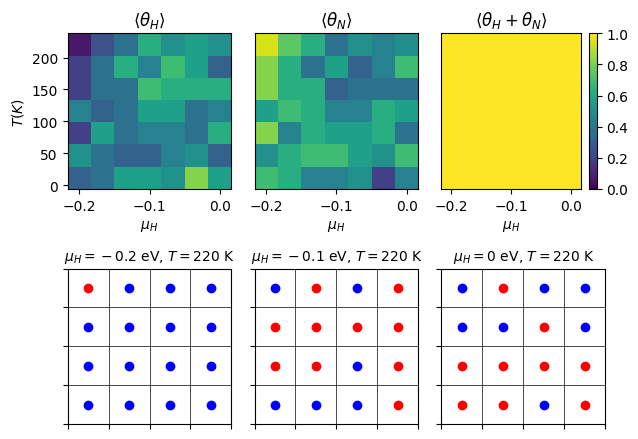

In [39]:
# Plot the final lattice configuration
# Plot the T-mu_A phase diagram
fig, axs = plt.subplot_mosaic([[0, 1, 2], [3, 4, 5]], figsize=(6.5, 4.5))
#fig, axs = plt.subplots(2, 3, figsize=(6.5, 4.5))


# Mean coverage of H
axs[0].pcolormesh(mus_A, Ts, mean_coverage_H.T, cmap='viridis', vmin=0, vmax=1)
axs[0].set_title(r'$\langle \theta_H \rangle$')
axs[0].set_xlabel(r'$\mu_H$')
axs[0].set_ylabel(r'$T(K)$')

# Mean coverage of N
axs[1].pcolormesh(mus_A, Ts, mean_coverage_N.T, cmap='viridis', vmin=0, vmax=1)
axs[1].set_title(r'$\langle \theta_N \rangle$')
axs[1].set_xlabel(r'$\mu_H$')
axs[1].set_yticks([])

# Mean total coverage
cax = axs[2].pcolormesh(mus_A, Ts, mean_coverage_H.T + mean_coverage_N.T, cmap='viridis', vmin=0, vmax=1)
axs[2].set_title(r'$\langle \theta_H + \theta_N \rangle$')
axs[2].set_xlabel(r'$\mu_H$')
axs[2].set_yticks([])
fig.colorbar(cax, ax=axs[2], location='right', fraction=0.1)

fontisize=10
# mu_A = -0.2 eV and T = 0.01 / k
axs[3] = plot_lattice(final_lattice[0, 6], axs[3], r'$\mu_H = -0.2$ eV, $T = 220$ K')
axs[3].set_title(r'$\mu_H = -0.2$ eV, $T = 220$ K', fontsize=fontisize)

# mu_A = -0.1 eV and T = 0.01 / k
axs[4] = plot_lattice(final_lattice[3, 6], axs[4], r'$\mu_H = -0.1$ eV, $T = 220$ K')
axs[4].set_title(r'$\mu_H = -0.1$ eV, $T = 220$ K', fontsize=fontisize)

# mu_A = 0 eV and T = 0.01 / k
axs[5] = plot_lattice(final_lattice[6, 6], axs[5], r'$\mu_H = 0$ eV, $T = 220$ K')
axs[5].set_title(r'$\mu_H = 0$ eV, $T = 220$ K', fontsize=fontisize)

plt.tight_layout()
plt.show()

In [40]:
#Immiscible Nitrogen and Hydrogen 

import numpy as np
import matplotlib.pyplot as plt

#A=Hydrogen->Varying value, limiting reagent
#B=Nitrogen->Constant value, excess 

# Parameters
size = 4
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7)
Ts = np.linspace(0.001, 0.019, 7)

params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1,
            'epsilon_B': -0.1,
            'epsilon_AA': -0.05,
            'epsilon_BB': -0.05,
            'epsilon_AB': 0.05,
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k))
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_H = np.zeros((len(mus_A), len(Ts)))
mean_coverage_N = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_H, coverage_N = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_H[i // len(Ts), i % len(Ts)] = np.mean(coverage_H[-1000:])
    mean_coverage_N[i // len(Ts), i % len(Ts)] = np.mean(coverage_N[-1000:])

Ts=Ts/(8.617*10**-5) #Convert to Kelvin


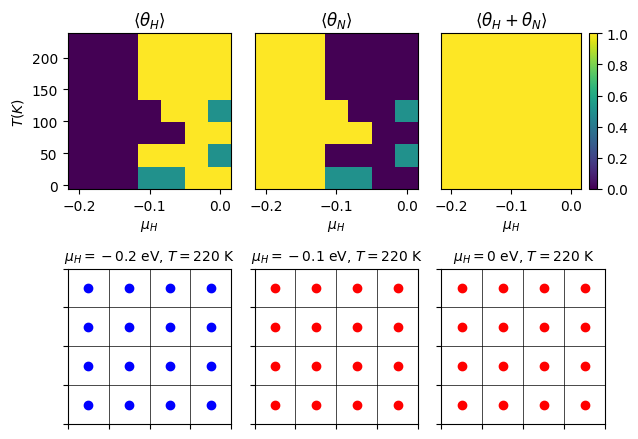

In [41]:
# Plot the final lattice configuration
# Plot the T-mu_A phase diagram
fig, axs = plt.subplot_mosaic([[0, 1, 2], [3, 4, 5]], figsize=(6.5, 4.5))
#fig, axs = plt.subplots(2, 3, figsize=(6.5, 4.5))


# Mean coverage of H
axs[0].pcolormesh(mus_A, Ts, mean_coverage_H.T, cmap='viridis', vmin=0, vmax=1)
axs[0].set_title(r'$\langle \theta_H \rangle$')
axs[0].set_xlabel(r'$\mu_H$')
axs[0].set_ylabel(r'$T(K)$')

# Mean coverage of N
axs[1].pcolormesh(mus_A, Ts, mean_coverage_N.T, cmap='viridis', vmin=0, vmax=1)
axs[1].set_title(r'$\langle \theta_N \rangle$')
axs[1].set_xlabel(r'$\mu_H$')
axs[1].set_yticks([])

# Mean total coverage
cax = axs[2].pcolormesh(mus_A, Ts, mean_coverage_H.T + mean_coverage_N.T, cmap='viridis', vmin=0, vmax=1)
axs[2].set_title(r'$\langle \theta_H + \theta_N \rangle$')
axs[2].set_xlabel(r'$\mu_H$')
axs[2].set_yticks([])
fig.colorbar(cax, ax=axs[2], location='right', fraction=0.1)

fontisize=10
# mu_A = -0.2 eV and T = 0.01 / k
axs[3] = plot_lattice(final_lattice[0, 6], axs[3], r'$\mu_H = -0.2$ eV, $T = 220$ K')
axs[3].set_title(r'$\mu_H = -0.2$ eV, $T = 220$ K', fontsize=fontisize)

# mu_A = -0.1 eV and T = 0.01 / k
axs[4] = plot_lattice(final_lattice[3, 6], axs[4], r'$\mu_H = -0.1$ eV, $T = 220$ K')
axs[4].set_title(r'$\mu_H = -0.1$ eV, $T = 220$ K', fontsize=fontisize)

# mu_A = 0 eV and T = 0.01 / k
axs[5] = plot_lattice(final_lattice[6, 6], axs[5], r'$\mu_H = 0$ eV, $T = 220$ K')
axs[5].set_title(r'$\mu_H = 0$ eV, $T = 220$ K', fontsize=fontisize)

plt.tight_layout()
plt.show()

In [42]:
#Like dissolves unLike

import numpy as np
import matplotlib.pyplot as plt

#A=Hydrogen->Varying value, limiting reagent
#B=Nitrogen->Constant value, excess 

# Parameters
size = 4
n_steps = 10000
mus_A = np.linspace(-0.2, 0, 7)
Ts = np.linspace(0.001, 0.019, 7)

params = []
for mu_A in mus_A:
    for T in Ts:
        params.append({
            'epsilon_A': -0.1,
            'epsilon_B': -0.1,
            'epsilon_AA': 0.05,
            'epsilon_BB': 0.05,
            'epsilon_AB': -0.05,
            'mu_A': mu_A,
            'mu_B': -0.1,
            'T': T  # Temperature (in units of k))
        })

# Run the simulation
np.random.seed(42)
final_lattice = np.zeros((len(mus_A), len(Ts), size, size))
mean_coverage_H = np.zeros((len(mus_A), len(Ts)))
mean_coverage_N = np.zeros((len(mus_A), len(Ts)))
for i, param in enumerate(params):
    lattice, coverage_H, coverage_N = run_simulation(size, n_steps, param)
    final_lattice[i // len(Ts), i % len(Ts)] = lattice
    mean_coverage_H[i // len(Ts), i % len(Ts)] = np.mean(coverage_H[-1000:])
    mean_coverage_N[i // len(Ts), i % len(Ts)] = np.mean(coverage_N[-1000:])

Ts=Ts/(8.617*10**-5) #Convert to Kelvin

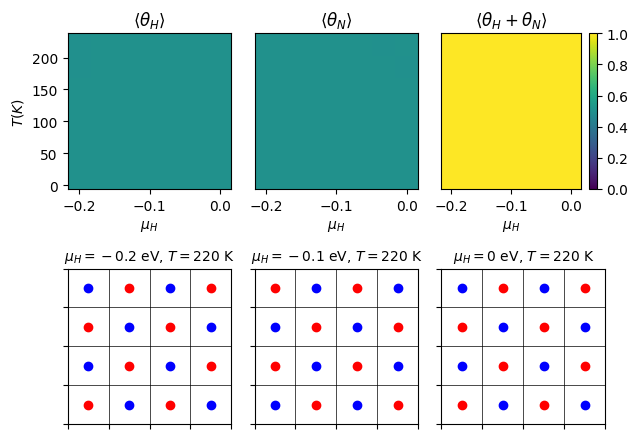

In [43]:
# Plot the final lattice configuration
# Plot the T-mu_A phase diagram
fig, axs = plt.subplot_mosaic([[0, 1, 2], [3, 4, 5]], figsize=(6.5, 4.5))
#fig, axs = plt.subplots(2, 3, figsize=(6.5, 4.5))


# Mean coverage of H
axs[0].pcolormesh(mus_A, Ts, mean_coverage_H.T, cmap='viridis', vmin=0, vmax=1)
axs[0].set_title(r'$\langle \theta_H \rangle$')
axs[0].set_xlabel(r'$\mu_H$')
axs[0].set_ylabel(r'$T(K)$')

# Mean coverage of N
axs[1].pcolormesh(mus_A, Ts, mean_coverage_N.T, cmap='viridis', vmin=0, vmax=1)
axs[1].set_title(r'$\langle \theta_N \rangle$')
axs[1].set_xlabel(r'$\mu_H$')
axs[1].set_yticks([])

# Mean total coverage
cax = axs[2].pcolormesh(mus_A, Ts, mean_coverage_H.T + mean_coverage_N.T, cmap='viridis', vmin=0, vmax=1)
axs[2].set_title(r'$\langle \theta_H + \theta_N \rangle$')
axs[2].set_xlabel(r'$\mu_H$')
axs[2].set_yticks([])
fig.colorbar(cax, ax=axs[2], location='right', fraction=0.1)

fontisize=10
# mu_A = -0.2 eV and T = 0.01 / k
axs[3] = plot_lattice(final_lattice[0, 6], axs[3], r'$\mu_H = -0.2$ eV, $T = 220$ K')
axs[3].set_title(r'$\mu_H = -0.2$ eV, $T = 220$ K', fontsize=fontisize)

# mu_A = -0.1 eV and T = 0.01 / k
axs[4] = plot_lattice(final_lattice[3, 6], axs[4], r'$\mu_H = -0.1$ eV, $T = 220$ K')
axs[4].set_title(r'$\mu_H = -0.1$ eV, $T = 220$ K', fontsize=fontisize)

# mu_A = 0 eV and T = 0.01 / k
axs[5] = plot_lattice(final_lattice[6, 6], axs[5], r'$\mu_H = 0$ eV, $T = 220$ K')
axs[5].set_title(r'$\mu_H = 0$ eV, $T = 220$ K', fontsize=fontisize)

plt.tight_layout()
plt.show()